## Pandas analysis

In the following a series of exercises is proposed on a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGA's. Each measurement (i.e. each raw) consists of the address of the TDC providing the signal, 'FPGA' and 'TDC_Channel, and the timing information itself, 'ORBIT_CNT', 'BX_COUNTER' and 'TDC_MEAS'. Each TDC count correspond 25/30 ns, whereas the BX_COUNTER feauters gets updated every 25 ns and the ORBIT_CNT every 'x' BX_COUNTER. You can see these way of storing the time as similar to hours, minutes and seconds.

1\. Create a Pandas DataFrame by read N raws of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of raws and larger that 10k.

2\. Find out the value of 'x'

3\. Find out how much the data taking lasted. You can either make an estimate on the baseis of the fraction of the measurements (raws) you read, or perform this check precisely by reading out the whole dataset

4\. Create a new column with the actual time in ns (as a combination of the other three columns with timing information)

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1

6\. Create a new DataFrame with only the raws with HEAD=1

7\. Make two occupancy plots (one per FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# EX 1

In [2]:
N=1310720
file_name="/Users/marco/Desktop/laboratorio fisica computazionale/data/data_000637.txt"
data=pd.read_csv(file_name, nrows=N)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
5,1,0,63,3869200167,2762,4
6,1,0,61,3869200167,2772,14
7,1,0,139,3869200167,2776,0
8,1,0,62,3869200167,2774,21
9,1,0,60,3869200167,2788,7


# EX 2

In [3]:
BX_min=data['BX_COUNTER'].min()

x=(data['BX_COUNTER'].max()+1-BX_min)*25
print("il periodo è x=",x,"secondi")

il periodo è x= 89100 secondi


# EX 3

In [4]:
#durata=(data['ORBIT_CNT'].max()-data['ORBIT_CNT'].min())*x+
data['timens']=data['ORBIT_CNT']*x+data['TDC_MEAS']*25/30+data['BX_COUNTER']*25
durata=data['timens'].max()-data['timens'].min()
print("la durata è",durata*1e-9, "secondi")

la durata è 0.9804162533125 secondi


# EX 4

vedi es 3

# EX 5

In [5]:
datarand=data.copy()
datarand['HEAD']=np.random.randint(0,2,len(data))
datarand

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,timens
0,0,0,123,3869200167,2374,26,3.447457e+14
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
5,1,0,63,3869200167,2762,4,3.447457e+14
6,1,0,61,3869200167,2772,14,3.447457e+14
7,0,0,139,3869200167,2776,0,3.447457e+14
8,1,0,62,3869200167,2774,21,3.447457e+14
9,0,0,60,3869200167,2788,7,3.447457e+14


# EX 6

In [6]:
data1=datarand[datarand.HEAD==1]
data1

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,timens
1,1,0,124,3869200167,2374,27,3.447457e+14
2,1,0,63,3869200167,2553,28,3.447457e+14
3,1,0,64,3869200167,2558,19,3.447457e+14
4,1,0,64,3869200167,2760,25,3.447457e+14
5,1,0,63,3869200167,2762,4,3.447457e+14
6,1,0,61,3869200167,2772,14,3.447457e+14
8,1,0,62,3869200167,2774,21,3.447457e+14
10,1,1,7,3869200167,2785,4,3.447457e+14
13,1,0,36,3869200167,2791,23,3.447457e+14
15,1,1,139,3869200167,2797,0,3.447457e+14


# EX 7

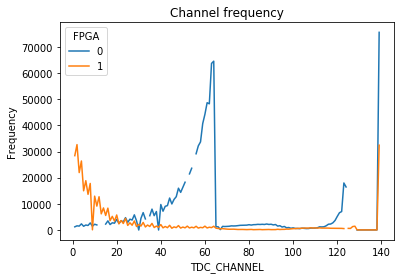

In [7]:
datagruppo=data.groupby(['FPGA','TDC_CHANNEL']).sum()
datagruppo.unstack('FPGA')['HEAD'].plot()
plt.ylabel('Frequency')
plt.title('Channel frequency')
plt.show()

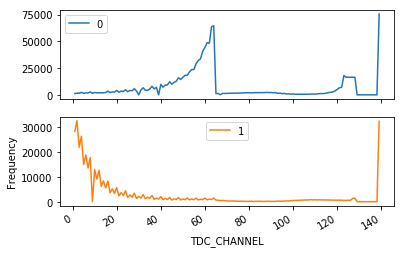

In [13]:
fill=datagruppo.unstack('FPGA')['HEAD'].fillna(method='pad').plot(subplots=True)
plt.ylabel('Frequency')

plt.show()


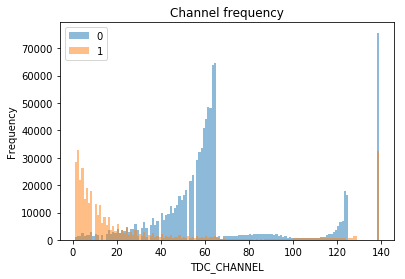

In [15]:
#usando l'istogramma
hist = data.groupby(['FPGA'])

n = data.TDC_CHANNEL.max()-data.TDC_CHANNEL.min()
hist.TDC_CHANNEL.plot(kind = 'hist', bins = n, alpha = 0.5)
plt.ylabel('Frequency')
plt.xlabel('TDC_CHANNEL')
plt.title('Channel frequency')
plt.legend()
plt.show()

# EX 8

In [59]:
#numero canali rumorosi
i=3

u=datagruppo.sort_values(by="HEAD", ascending=False)
print('primi tre canali per maggior numero di conteggi per FPGA 0:\n',u.loc[0,:]['HEAD'].head(i))  
print('\nprimi tre canali per maggior numero di conteggi per FPGA 1:\n',u.loc[1,:]['HEAD'].head(i))
#ricorda che nel caso a multiindice loc può prendere tutti gli elementi con : solo se specifico l'indice "più esterno"
#per esempio non varrebbe se io facessi [:,0]

primi tre canali per maggior numero di conteggi per FPGA 0:
 TDC_CHANNEL
139    75617
64     64581
63     63724
Name: HEAD, dtype: int64

primi tre canali per maggior numero di conteggi per FPGA 1:
 TDC_CHANNEL
2      32669
139    32442
1      28438
Name: HEAD, dtype: int64


# EX 9

In [54]:
dataorb=data.groupby(['ORBIT_CNT']).sum()
print('il numero di orbite distinte vale:')
dataorb.describe().head(1)


il numero di orbite distinte vale:


,HEAD,FPGA,TDC_CHANNEL,BX_COUNTER,TDC_MEAS,timens
count,11001.0,11001.0,11001.0,11001.0,11001.0,11001.0


In [55]:
dataorb=data.groupby(['TDC_CHANNEL','ORBIT_CNT']).sum()
v=dataorb.sort_values(by="TDC_CHANNEL", ascending=False)
c=v.loc[139,:]
#c.unstack('HEAD')
print('il numero di conteggi ottenuti dai canali 139 vale:')
c.describe().head(1)


il numero di conteggi ottenuti dai canali 139 vale:


,HEAD,FPGA,BX_COUNTER,TDC_MEAS,timens
count,10976.0,10976.0,10976.0,10976.0,10976.0
